In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from pytorch_revgrad import RevGrad

train_MNIST = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_MNIST = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

train_USPS = datasets.USPS('USPS', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_USPS = datasets.USPS('USPS', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

trainset_MNIST = torch.utils.data.DataLoader(train_MNIST, batch_size=32, shuffle=True)
testset_MNIST = torch.utils.data.DataLoader(test_MNIST, batch_size=32, shuffle=False)

trainset_USPS = torch.utils.data.DataLoader(train_USPS, batch_size=32, shuffle=True)
testset_USPS = torch.utils.data.DataLoader(test_USPS, batch_size=32, shuffle=False)

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
torch.cuda.device_count()

Running on the GPU


1

In [3]:
# defining the transformation

p = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor()
])

In [4]:
# function that transforms the data according to how it is done in the paper. First interpolating so that images are 32x32 and than performing 'random' 28x28 crop

def transformdata(data):
    data_transformed = [] # initializing the entire (batched) dataset as an empty list
    
    for batch in data:
        
        images = batch[0]
        labels = batch[1]
        
        images_transformed = torch.zeros(size=torch.Size([32, 1, 28, 28])) # initializing the transformed images with the same shape as images (32, 1, 28, 28)

        for i in range(0, len(images)):
            
            image = images[i]
            
            image_transformed = p(image) # transforming the image with predefined transformation "p"
            images_transformed[i] = image_transformed # replacing zero tensor (1, 28, 28) in images_transformed with the transformed image
            
        batch_transformed = [images_transformed, labels] # transformed batch is simply a list of batch of images in [0] and batch of labels in [1]
    
        data_transformed.append(batch_transformed) # appending to the empty dataset list
        
    return data_transformed

In [5]:
# transforming data

train_MNIST_transformed = transformdata(trainset_MNIST)
test_MNIST_transformed = transformdata(testset_MNIST)
train_USPS_transformed = transformdata(trainset_USPS)
test_USPS_transformed = transformdata(testset_USPS)

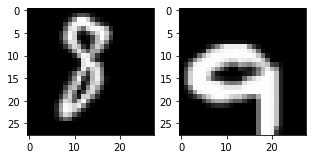

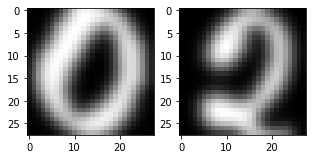

In [6]:
# plotting 2 images from MNIST datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_MNIST_0 = train_MNIST_transformed[0]
images0 = batch_MNIST_0[0]

plt.figure(figsize=(5,5)) # specifying the overall grid size

for i in range(2):
    plt.subplot(1,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(images0[i].view(28,28), cmap="gray")

plt.show()

# plotting 2 images from USPS datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_USPS_0 = train_USPS_transformed[0]

images0 = batch_USPS_0[0]

plt.figure(figsize=(5,5)) # specifying the overall grid size


for i in range(2):
    plt.subplot(1,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(images0[i].view(28,28), cmap="gray")

plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F
# from model import fNet, gNet, Discriminator, hSim, SimNet

In [8]:
def init_weights_disc(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight)
        nn.init.uniform_(m.bias)
#         m.bias.data.uniform_()
#         m.bias.data.fill_(0.01) # do we need something like this?

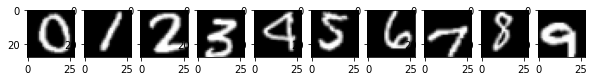

In [21]:
# take prototypes from MNIST (in the future they have to be chosen randomly --> shuffle?)
prototype_images = [0] * 10



for source_data in train_MNIST_transformed:
    X_source, y_source = source_data
    
    for j in range(0, len(y_source)):
        
        if torch.sum(torch.Tensor(prototype_images[int(y_source[j])])) == 0:
            prototype_images[int(y_source[j])] = X_source[j].view(1, 1, 28, 28)
            
plt.figure(figsize=(10,10)) # specifying the overall grid size


for i in range(10):
    plt.subplot(1,10,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(prototype_images[i].view(28,28), cmap="gray")
    
    prototype_images[i] = prototype_images[i].to(device)
    
    
plt.show()



In [28]:
class fNet(nn.Module):
    def __init__(self):
        super(fNet, self).__init__()
        
        self.restored = False

        self.conv1 = nn.Conv2d(1, 64, 5)   # 1st conv layer INPUT [1 x 28 x 28] OUTPUT [64 x 12 x 12]
        self.conv2 = nn.Conv2d(64, 64, 5)  # 2nd conv layer INPUT [64 x 12 x 12] OUTPUT [64 x 4 x 4]
        self.conv3 = nn.Conv2d(64, 128, 5) # 3rd conv layer INPUT [64 x 4 x 4] OUTPUT [128 x 1 x 1]
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05) # batch normalisation
        self.pool = nn.MaxPool2d(2, 2, padding=1)
         
    def forward(self, x):
        output = self.pool(F.relu(self.bn1(self.conv1(x))))
        output = self.pool(F.relu(self.bn1(self.conv2(output))))
        output = F.relu(self.conv3(output))
        output = output.view(-1, 128 * 1 * 1)
        return output
    
    
class gNet(nn.Module):
    def __init__(self):
        super(gNet, self).__init__()
        
        self.restored = False
                
        self.conv1 = nn.Conv2d(1, 64, 5)      # 1st conv layer INPUT [1 x 28 x 28]  OUTPUT [64 x 12 x 12]
        self.conv2 = nn.Conv2d(64, 64, 5)     # 2nd conv layer INPUT [64 x 12 x 12] OUTPUT [64 x 4 x 4]
        self.conv3 = nn.Conv2d(64, 128, 5)    # 3rd conv layer INPUT [64 x 4 x 4]   OUTPUT [128 x 1 x 1]
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05) # batch normalisation
        self.pool = nn.MaxPool2d(2, 2, padding=1)
        
         
    def forward(self, x):
        output = self.pool(F.relu(self.bn1(self.conv1(x))))
        output = self.pool(F.relu(self.bn1(self.conv2(output))))
        output = F.relu(self.conv3(output))
        output = output.view(-1, 128 * 1 *1)
        return output


    def calcproto(self, class_list):
        
        g_output = []
        
        for class_image in class_list:
            g_output_class = self.forward(class_image)
            g_output.append(g_output_class)
        
        num_classes = len(g_output) # number of classes (10 in Digits experiment)
        num_features = g_output_class.shape[1] # number of features (128 in Digits experiment)
        
        prototypes = torch.Tensor(size=torch.Size([num_features, num_classes])).to(device)
        
        class_count = 0
        
        for g_output_class in g_output:
            
            prototype = torch.mean(g_output_class, dim=0) # calculating the prototype for each class
            prototypes[:,class_count] = prototype
                        
            class_count += 1
                    
        return prototypes
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.restored = False

        
        self.layer = nn.Sequential(
            RevGrad(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2)
#             RevGrad()
        )
        
    def forward(self, x):
        output = self.layer(x)
        output = output/torch.max(output)
        output = F.softmax(output, dim=1) 
        
        return output[:, 0]
    
class hSim(nn.Module):
    def __init__(self):
        super().__init__()
    

        self.restored = False
        
        
        self.U = nn.Parameter(torch.rand(size=(512, 128), requires_grad=True))
        self.V = nn.Parameter(torch.rand(size=(512, 128), requires_grad=True))
        
    def forward(self, f_batch, mu_c):
        
        batchsize = len(f_batch) # batchsize = 10
        num_classes = mu_c.shape[1] # num_classes = 2
        
        h_batch = torch.zeros(size=[batchsize, num_classes])
        
        for i in range(0, len(f_batch)):
        
            f_i = f_batch[i]
            
            fac1 = torch.matmul(self.U, f_i)
            fac1_t = fac1.t()
                             
            fac2 = torch.matmul(self.V, mu_c)
            
            h = torch.matmul(fac1_t, fac2)
            h = F.log_softmax(h, dim=0)
    
            h_batch[i] = h
            
        
        return h_batch  

    
class SimNet(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.restored = False
    
        self.fnet = fNet()
        self.gnet = gNet()
        self.disc = Discriminator()
        self.hsim = hSim()
        
        
    def forward(self, f_input, g_input):
        # f_input is batch of images
        # g_input should be a list (in the future maybe change to tensor?) of one (while training --> randomly chosen) or more (while testing --> every from test_batch) image(s) of every class
        
        f_output = self.fnet(f_input)
        prototypes = self.gnet.calcproto(g_input)
                                
        Regularizer = torch.norm(torch.matmul(prototypes, prototypes.t()) - torch.eye(128).to(device))
        
#         print(torch.matmul(prototypes, prototypes.t()))
        
        Regularizer = Regularizer*Regularizer
        
#         print(prototypes)
                
        class_output = self.hsim(f_output, prototypes)
        disc_output = self.disc(f_output)
        
        return [class_output, disc_output, Regularizer] 

In [31]:
gamma_reg = 0.01
lambda_loss= 0.5

simnet = SimNet().to(device)
simnet.apply(init_weights_disc)

# optimizerSimNet = torch.optim.SGD([
#                                     {'params': simnet.disc.parameters(), 'lr': 1e-3},
#                                     {'params': simnet.hsim.parameters(), 'lr': 1e-3},
#                                     {'params': simnet.fnet.parameters()},
#                                     {'params': simnet.gnet.parameters()}],                                 
#                                 lr=1e-3, momentum=0.99, weight_decay=1e-5)

optimizerSimNet = torch.optim.Adam([
                                    {'params': simnet.disc.parameters(), 'lr': 1e-4},
                                    {'params': simnet.hsim.parameters(), 'lr': 1e-4},
                                    {'params': simnet.fnet.parameters()},
                                    {'params': simnet.gnet.parameters()}],                             
                                lr=1e-5)

loss_disc_list = []
loss_class_list = []

for epoch in range(3): # 3 full passes over the data
    
    num_batches = len(train_USPS_transformed)

    for i in range(0, num_batches):
        
        MNIST_batch = train_MNIST_transformed[i]
        USPS_batch = train_USPS_transformed[i]

        
        X_MNIST, y_MNIST = MNIST_batch
        X_USPS, y_USPS = USPS_batch
        
        X_MNIST, y_MNIST = X_MNIST.to(device), y_MNIST.to(device)
        X_USPS, y_USPS = X_USPS.to(device), y_USPS.to(device)
        
                
        simnet.zero_grad()
                
        [source_class_output, source_domain_output, Regularizer] = simnet(X_MNIST, prototype_images)
        [target_class_output, target_domain_output, Regularizer] = simnet(X_USPS, prototype_images)

        
        source_class_output = source_class_output.to(device)
        target_class_output = target_class_output.to(device)

#         loss_class = 0
        
###### 'Our' implementation of classifier loss as described in the paper ######
                
#         for j in range(0,len(y_MNIST)):
#             h_jj = source_class_output[j][y_MNIST[j]]
#             h_jk = torch.exp(source_class_output[j]) # this term explodes if softmax is not applied?
#             h_k = torch.sum(h_jk)
            
#             loss_class -= (h_jj - torch.log(h_k + 1e-7))
            
# #         print(Regularizer) # this gets absurdly large?
            
#         loss_class += gamma_reg*Regularizer

##### Cross_entropy classifier loss #####
            
#         print(gamma_reg*Regularizer)
#         print(source_class_output)
        
#         loss_class = F.cross_entropy(source_class_output, y_MNIST) + gamma_reg * Regularizer

#         print(Regularizer)

        loss_class = F.nll_loss(source_class_output, y_MNIST) + gamma_reg * Regularizer

        loss_disc = - torch.mean(torch.log(source_domain_output + 1e-7)) - torch.mean(torch.log(1 - target_domain_output+1e-7))

        total_loss = loss_class - lambda_loss * loss_disc        
        total_loss.backward()
    
        optimizerSimNet.step()
        
#         print("loss_class: " + str(loss_class))
#         print("loss_disc: " + str(loss_disc))

        loss_disc_list.append(loss_disc)
        loss_class_list.append(loss_class)       
    
    
#         if i == num_batches-1:
#             print("loss_class: " + str(loss_class))
#             print("loss_disc: " + str(loss_disc))

loss_class: tensor(16508.7246, device='cuda:0', grad_fn=<AddBackward0>)
loss_disc: tensor(1.3863, device='cuda:0', grad_fn=<SubBackward0>)
loss_class: tensor(9866.9590, device='cuda:0', grad_fn=<AddBackward0>)
loss_disc: tensor(1.3863, device='cuda:0', grad_fn=<SubBackward0>)
loss_class: tensor(8306.8232, device='cuda:0', grad_fn=<AddBackward0>)
loss_disc: tensor(1.3863, device='cuda:0', grad_fn=<SubBackward0>)
loss_class: tensor(6047.7148, device='cuda:0', grad_fn=<AddBackward0>)
loss_disc: tensor(1.3863, device='cuda:0', grad_fn=<SubBackward0>)
loss_class: tensor(8644.2441, device='cuda:0', grad_fn=<AddBackward0>)
loss_disc: tensor(1.3863, device='cuda:0', grad_fn=<SubBackward0>)
loss_class: tensor(6726.7007, device='cuda:0', grad_fn=<AddBackward0>)
loss_disc: tensor(1.3864, device='cuda:0', grad_fn=<SubBackward0>)
loss_class: tensor(8650.5938, device='cuda:0', grad_fn=<AddBackward0>)
loss_disc: tensor(1.3863, device='cuda:0', grad_fn=<SubBackward0>)
loss_class: tensor(7691.5952, dev

KeyboardInterrupt: 

In [49]:
for test_batch in test_USPS_transformed:
    
    X, y = test_batch
    [class_output, domain_output, Reg] = simnet(X, prototype_images)
    
    print(domain_output)

    print(torch.argmax(class_output, dim=1))

    
    print(class_output)
    print(y)
    
    break

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<SelectBackward>)
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 7])
tensor([[-2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00,
         -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00],
        [-2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00,
         -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00],
        [-2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00,
         -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00],
        [-2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00,
         -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00],
        [-2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00, -2.3026e+00,
         -2.3026e+00, -2.3026e+00, -2.3

In [28]:
torch.rand(size=(512, 128))

tensor([[0.5726, 0.9883, 0.1414,  ..., 0.0374, 0.7231, 0.9661],
        [0.2662, 0.5542, 0.1316,  ..., 0.9427, 0.6415, 0.9345],
        [0.7796, 0.4761, 0.7930,  ..., 0.2161, 0.4227, 0.7010],
        ...,
        [0.8246, 0.6484, 0.1934,  ..., 0.2324, 0.9319, 0.5450],
        [0.3054, 0.1861, 0.6735,  ..., 0.7878, 0.0370, 0.4387],
        [0.3510, 0.5852, 0.9645,  ..., 0.3491, 0.5956, 0.2489]])